In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder
import category_encoders as ce

In [ ]:
import gc

# Split de train/validation y encodeado

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Organización de Datos/TP2/dataset_v2/train.parq', columns=['attack_time', 'watcher_country', 'watcher_as_name', 'attacker_country', 'attacker_as_name', 'attack_type',  'watcher_uuid_enum','attacker_ip_enum', 'label' ])

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df['watcher_country'] = df.watcher_country.cat.add_categories('NN').fillna('NN')
df['watcher_as_name'] = df.watcher_as_name.cat.add_categories('NN').fillna('NN')
df['attacker_as_name'] = df.attacker_as_name.cat.add_categories('NN').fillna('NN')
df['attacker_country'] = df.attacker_country.cat.add_categories('NN').fillna('NN')

In [ ]:
df['watcher_uuid_enum'] = df.watcher_uuid_enum.astype('category')

In [ ]:
df.rename(columns={'attacker_as_name':'attacker', 'watcher_as_name':'watcher', 'watcher_uuid_enum':'watcher_id'}, inplace=True)

In [ ]:
def obtener_rangos_horarios(hora):
    if 0 <= hora < 12:
        return '0-12'
    else:
        return '12-24'

In [ ]:
df['hora'] = df['attack_time'].dt.hour
df['day'] = df['attack_time'].dt.day_name().astype('category')
df['hour_range'] = df['hora'].map(lambda x: obtener_rangos_horarios(x)).astype('category')
df.drop(['hora'], axis=1,  inplace=True)
df.drop(['attack_time'], axis=1, inplace=True)

In [ ]:
df['attack_protocol'] = df['attack_type'].map(lambda x: x.split(':')[0]).astype('category')
df['attack_type'] = df['attack_type'].map(lambda x: x.split(':')[1]).astype('category')

In [ ]:
attacker_ips = df['attacker_ip_enum'].unique()

In [ ]:
ips_train, ips_validation = train_test_split(attacker_ips, test_size=0.15, random_state=5)

In [ ]:
train = df[df['attacker_ip_enum'].isin(ips_train)]
validation = df[df['attacker_ip_enum'].isin(ips_validation)]

In [ ]:
train = train.drop(['attacker_ip_enum'], axis=1)
validation = validation.drop(['attacker_ip_enum'], axis=1)

In [ ]:
train.drop_duplicates(inplace=True) #se generan repetidas al dividir time en dia/rango_horario que para entrenar no usaré

In [ ]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)

In [ ]:
X_train = train.drop(['label'], axis=1)
y_train = train[['label']]

X_validation = validation.drop(['label'], axis=1)
y_validation = validation[['label']]

In [ ]:
del df
del train
del validation
del attacker_ips
del ips_train
del ips_validation

In [ ]:
me_attacker_country = TargetEncoder()

X_train['attacker_country_mean'] = me_attacker_country.fit_transform(X_train['attacker_country'], y_train)
X_validation['attacker_country_mean'] = me_attacker_country.transform(X_validation['attacker_country'])

X_train = X_train.drop('attacker_country', axis=1)
X_validation = X_validation.drop('attacker_country', axis=1)

In [ ]:
me_watcher_country = TargetEncoder()

X_train['watcher_country_mean'] = me_watcher_country.fit_transform(X_train['watcher_country'], y_train)
X_validation['watcher_country_mean'] = me_watcher_country.transform(X_validation['watcher_country'])

X_train = X_train.drop('watcher_country', axis=1)
X_validation = X_validation.drop('watcher_country', axis=1)

In [ ]:
me_attacker = TargetEncoder()

X_train['attacker_mean'] = me_attacker.fit_transform(X_train['attacker'], y_train)
X_validation['attacker_mean'] = me_attacker.transform(X_validation['attacker'])

X_train = X_train.drop('attacker', axis=1)
X_validation = X_validation.drop('attacker', axis=1)

In [ ]:
me_watcher = TargetEncoder()

X_train['watcher_mean'] = me_watcher.fit_transform(X_train['watcher'], y_train)
X_validation['watcher_mean'] = me_watcher.transform(X_validation['watcher'])

X_train = X_train.drop('watcher', axis=1)
X_validation = X_validation.drop('watcher', axis=1)

In [ ]:
me_watcher_id = TargetEncoder()

X_train['watcher_id_mean'] = me_watcher_id.fit_transform(X_train['watcher_id'], y_train)
X_validation['watcher_id_mean'] = me_watcher_id.transform(X_validation['watcher_id'])

X_train = X_train.drop('watcher_id', axis=1)
X_validation = X_validation.drop('watcher_id', axis=1)

In [ ]:
ohe_attack_type = OneHotEncoder(drop='first')

encoded_attack_type_train = ohe_attack_type.fit_transform(X_train[['attack_type']]).todense().astype(np.uint8)
nuevas_col_train = pd.DataFrame(encoded_attack_type_train).add_prefix('attack_type_')
del encoded_attack_type_train
X_train = X_train.join(nuevas_col_train)
X_train = X_train.drop('attack_type', axis=1)
del nuevas_col_train


encoded_attack_type_validation = ohe_attack_type.transform(X_validation[['attack_type']]).todense().astype(np.uint8)
nuevas_col_validation = pd.DataFrame(encoded_attack_type_validation).add_prefix('attack_type_')
del encoded_attack_type_validation
X_validation = X_validation.join(nuevas_col_validation)
X_validation = X_validation.drop('attack_type', axis=1)
del nuevas_col_validation

In [ ]:
ohe_hour_range = OneHotEncoder(drop='first')
encoded_hour_range_train = ohe_hour_range.fit_transform(X_train[['hour_range']]).todense().astype(np.uint8)
encoded_hour_range_val = ohe_hour_range.transform(X_validation[['hour_range']]).todense().astype(np.uint8)

In [ ]:
X_train.hour_range = encoded_hour_range_train
X_validation.hour_range = encoded_hour_range_val

del encoded_hour_range_train
del encoded_hour_range_val

In [ ]:
ohe_day = OneHotEncoder(drop='first')

encoded_day_train = ohe_day.fit_transform(X_train[['day']]).todense().astype(np.uint8)
nuevas_col_train = pd.DataFrame(encoded_day_train).add_prefix('day_')
del encoded_day_train
X_train = X_train.join(nuevas_col_train)
X_train = X_train.drop('day', axis=1)
del nuevas_col_train


encoded_day_validation = ohe_day.transform(X_validation[['day']]).todense().astype(np.uint8)
nuevas_col_validation = pd.DataFrame(encoded_day_validation).add_prefix('day_')
del encoded_day_validation
X_validation = X_validation.join(nuevas_col_validation)
X_validation = X_validation.drop('day', axis=1)
del nuevas_col_validation

In [ ]:
be_attack_protocol = ce.BinaryEncoder(cols = ['attack_protocol'])
X_train = be_attack_protocol.fit_transform(X_train)
X_validation = be_attack_protocol.transform(X_validation)

In [ ]:
X_train['attack_protocol_0'] = X_train['attack_protocol_0'].astype(np.int8)
X_train['attack_protocol_1'] = X_train['attack_protocol_1'].astype(np.int8)
X_train['attack_protocol_2'] = X_train['attack_protocol_2'].astype(np.int8)
X_train['attack_protocol_3'] = X_train['attack_protocol_3'].astype(np.int8)

X_validation['attack_protocol_0'] = X_validation['attack_protocol_0'].astype(np.int8)
X_validation['attack_protocol_1'] = X_validation['attack_protocol_1'].astype(np.int8)
X_validation['attack_protocol_2'] = X_validation['attack_protocol_2'].astype(np.int8)
X_validation['attack_protocol_3'] = X_validation['attack_protocol_3'].astype(np.int8)

# Perceptrón

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron

In [ ]:
perceptron = Perceptron() #random_state=0

In [ ]:
params = [
    {'penalty': ['l2','l1','elasticnet', None]},
    {'alpha': [0.00009, 0.000095, 0.0001, 0.00011, 0.00015]},
    {'max_iter': [800, 900, 1000, 1100, 1200]}
]

In [ ]:
gs = GridSearchCV(perceptron, param_grid=params, scoring='f1')

In [ ]:
gs.fit(X_train, np.ravel(y_train))

GridSearchCV(estimator=Perceptron(),
             param_grid=[{'penalty': ['l2', 'l1', 'elasticnet', None]},
                         {'alpha': [9e-05, 9.5e-05, 0.0001, 0.00011, 0.00015]},
                         {'max_iter': [800, 900, 1000, 1100, 1200]}],
             scoring='f1')

In [ ]:
gs.best_params_

{'penalty': 'elasticnet'}

In [ ]:
model = gs.best_estimator_

In [ ]:
model.fit(X_train, np.ravel(y_train))

Perceptron(penalty='elasticnet')

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
y_pred = model.predict(X_train)

In [ ]:
f1_score(y_train, y_pred)

0.7435142684560877

In [ ]:
y_pred = model.predict(X_validation)

In [ ]:
f1_score(y_validation, y_pred)

0.5396031114374787

In [ ]:
weights = model.coef_[0]
features = X_train.columns

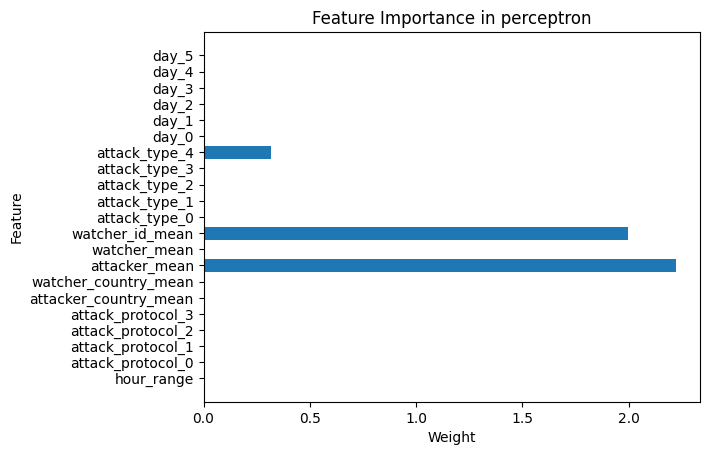

In [ ]:
import matplotlib.pyplot as plt

plt.barh(features, weights, align='center')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Importance in perceptron')
plt.show()

In [ ]:
X_train.to_pickle("X_train.pkl")
X_validation.to_pickle("X_validation.pkl")
y_train.to_pickle("y_train.pkl")
y_validation.to_pickle("y_validation.pkl")

#unpickled_df = pd.read_pickle("aa.pkl")

In [ ]:
del  X_train
del  X_validation
del  y_train
del  y_validation

# Test

In [ ]:
test = pd.read_parquet('/content/drive/MyDrive/Organización de Datos/TP2/dataset_v2/test.parq', columns=['attack_time', 'watcher_country', 'watcher_as_name', 'attacker_country', 'attacker_as_name', 'attack_type',  'watcher_uuid_enum','attacker_ip_enum'])

In [ ]:
test = test.drop_duplicates(subset='attacker_ip_enum').reset_index(drop=True)

In [ ]:
ips_test = test[['attacker_ip_enum']]
test = test.drop(['attacker_ip_enum'], axis=1)

In [ ]:
test['watcher_country'] = test.watcher_country.cat.add_categories('NN').fillna('NN')
test['watcher_as_name'] = test.watcher_as_name.cat.add_categories('NN').fillna('NN')
test['attacker_as_name'] = test.attacker_as_name.cat.add_categories('NN').fillna('NN')
test['attacker_country'] = test.attacker_country.cat.add_categories('NN').fillna('NN')

test['watcher_uuid_enum'] = test.watcher_uuid_enum.astype('category')

test.rename(columns={'attacker_as_name':'attacker', 'watcher_as_name':'watcher', 'watcher_uuid_enum':'watcher_id'}, inplace=True)

test['hora'] = test['attack_time'].dt.hour
test['day'] = test['attack_time'].dt.day_name().astype('category')
test['hour_range'] = test['hora'].map(lambda x: obtener_rangos_horarios(x)).astype('category')
test.drop(['hora'], axis=1,  inplace=True)
test.drop(['attack_time'], axis=1, inplace=True)

test['attack_protocol'] = test['attack_type'].map(lambda x: x.split(':')[0]).astype('category')
test['attack_type'] = test['attack_type'].map(lambda x: x.split(':')[1]).astype('category')

In [ ]:
test['attacker_country_mean'] = me_attacker_country.transform(test['attacker_country'])
test = test.drop('attacker_country', axis=1)

test['watcher_country_mean'] = me_watcher_country.transform(test['watcher_country'])
test = test.drop('watcher_country', axis=1)

test['attacker_mean'] = me_attacker.transform(test['attacker'])
test = test.drop('attacker', axis=1)

test['watcher_mean'] = me_watcher.transform(test['watcher'])
test = test.drop('watcher', axis=1)

test['watcher_id_mean'] = me_watcher_id.transform(test['watcher_id'])
test = test.drop('watcher_id', axis=1)

encoded_attack_type_test = ohe_attack_type.transform(test[['attack_type']]).todense().astype(np.uint8)
nuevas_col_test = pd.DataFrame(encoded_attack_type_test).add_prefix('attack_type_')
del encoded_attack_type_test
test = test.join(nuevas_col_test)
test = test.drop('attack_type', axis=1)
del nuevas_col_test

encoded_hour_range_test = ohe_hour_range.transform(test[['hour_range']]).todense().astype(np.uint8)
test.hour_range = encoded_hour_range_test
del encoded_hour_range_test

encoded_day_test = ohe_day.transform(test[['day']]).todense().astype(np.uint8)
nuevas_col_test = pd.DataFrame(encoded_day_test).add_prefix('day_')
del encoded_day_test
test = test.join(nuevas_col_test)
test = test.drop('day', axis=1)
del nuevas_col_test

test = be_attack_protocol.transform(test)
test['attack_protocol_0'] = test['attack_protocol_0'].astype(np.int8)
test['attack_protocol_1'] = test['attack_protocol_1'].astype(np.int8)
test['attack_protocol_2'] = test['attack_protocol_2'].astype(np.int8)
test['attack_protocol_3'] = test['attack_protocol_3'].astype(np.int8)

In [ ]:
y_pred = model.predict(test)

In [ ]:
pred_df = pd.concat([ips_test, pd.DataFrame(y_pred, columns = ['label'])], axis=1)

In [ ]:
pred_df.to_csv('/content/drive/MyDrive/Organización de Datos/TP2/predPerceptron.csv', index=False)

In [ ]:
pred_df

,attacker_ip_enum,label
0,7696,0
1,7543,0
2,7280,0
3,1538,0
4,285,0
...,...,...
49415,196304,0
49416,199918,0
49417,192446,0
49418,192056,0


0.52255 en kaggle